Download historical daily BTC/USD prices 

In [96]:
import requests
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.environ['ALHPA_AVANTAGE_API_KEY']
url = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=USD&apikey={}'.format(api_key)
r = requests.get(url)
data = r.json()

In [97]:
daily_data = data['Time Series (Digital Currency Daily)']
closing_prices = []
for day in daily_data.keys():
    closing_price = round(float(daily_data[day]['4b. close (USD)']), 2)
    closing_prices.append(closing_price)

"We got {} data points".format(len(closing_prices))

'We got 1000 data points'

Split dataset into batches of 5 sequential price points

In [98]:
time_steps = 5

In [99]:
chunks = [closing_prices[x:x+time_steps] for x in range(0, len(closing_prices), time_steps)]
train_test_split_index = int(0.8 * len(chunks))

Prepare training and test data

In [100]:
training_data = chunks[0:train_test_split_index]
test_data = chunks[train_test_split_index:]
len(training_data), training_data[0], len(test_data), test_data[0]


(160,
 [23248.86, 23141.57, 23492.09, 23554.85, 23157.07],
 40,
 [22719.71, 23455.52, 23821.61, 23107.39, 22797.16])

Turn training and test data into pytorch tensors

In [101]:
import torch
import torch.nn as nn

Here, I decided to divide the amounts in the train and test data by 10000 to mitigate the [exploding gradient problem](https://www.educative.io/answers/what-is-exploding-gradient-problem) encountred during training

In [102]:
COMMON_DIVISOR = 10000
train = torch.Tensor(training_data) / COMMON_DIVISOR
test = torch.Tensor(test_data) / COMMON_DIVISOR
train.shape, test.shape

(torch.Size([160, 5]), torch.Size([40, 5]))

In [103]:
input_to_output = nn.Linear(1 + time_steps, 1)
input_to_hidden = nn.Linear(1 + time_steps, time_steps)

Feed forward operation

In [104]:
def forward(input, hidden):
    combined_input = torch.cat((input, hidden), 1)
    output = input_to_output(combined_input)
    new_hidden = input_to_hidden(combined_input)
    return output, new_hidden

In [105]:
hidden = torch.zeros(1, time_steps)
for i in range(0, time_steps):
    input = train[0][i:i+1].unsqueeze(1)
    output, hidden = forward(input, hidden)
print(output)

tensor([[-0.2245]], grad_fn=<AddmmBackward0>)


Train the model in randomized batches in one epoch

In [106]:
batch_size = 20
learning_rate = 0.01
mse = nn.MSELoss()

def run_epoch(input_to_output, input_to_hidden):
    randomized_training_indices = torch.randperm(train.shape[0])
    losses = []
    # for each training batch
    for new_batch_start in range(0, len(randomized_training_indices), batch_size):
        batch_indices = [randomized_training_indices[x].item() for x in range(new_batch_start, new_batch_start+batch_size)]
        
        predictions = torch.zeros(len(batch_indices))
        outputs = torch.zeros(len(batch_indices))
        index = 0

        input_to_hidden.zero_grad()
        input_to_output.zero_grad()
    
        # for training data in batch
        for batch_index in batch_indices:

            hidden = torch.zeros(1, time_steps)
            single_train_data = train[batch_index]
            prediction = 0
            # for each time step
            for step in range(0, len(single_train_data - 1)):
                input = single_train_data[step:step+1].unsqueeze(1)
                prediction, hidden = forward(input, hidden)          
            
            actual = single_train_data[-1]
            predictions[index] = prediction
            outputs[index] = actual
            index += 1
        
        # calculate error
        loss = mse(predictions, outputs)
        losses.append(loss.item())

        # back propagation to adjust weights
        loss.backward()
        for p in input_to_hidden.parameters():
            p.data.add_(p.grad.data, alpha=-learning_rate)
        input_to_hidden.grad = None

        for p in input_to_output.parameters():
            p.data.add_(p.grad.data, alpha=-learning_rate)
        input_to_output.grad = None
    
    return sum(losses)/ len(losses)

In [125]:
input_to_output = nn.Linear(1 + time_steps, 1)
input_to_hidden = nn.Linear(1 + time_steps, time_steps)
avg_losses = []
for i in range(0, 201):
    avg_loss = run_epoch(input_to_output, input_to_hidden)
    avg_losses.append(avg_loss)

Plot the averafge loss per epoch over time

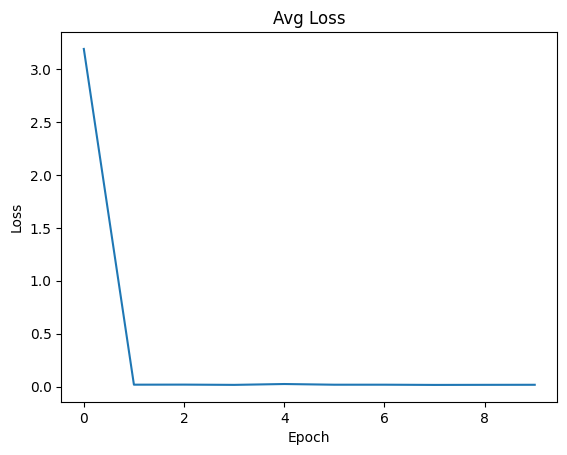

In [124]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, len(avg_losses))
y = np.array(avg_losses)

# plotting
plt.title("Avg Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x, y)
plt.show()

Check prediction on test data

In [127]:
for i in range(0, test.shape[0]):
    single_test_data = torch.clone(test[i])
    x = single_test_data[0:len(single_test_data) - 1]

    hidden = torch.zeros(1, time_steps)
    prediction = 0
    # for each time step
    for item in x:
        input = torch.Tensor([item]).unsqueeze(1)
        prediction, hidden = forward(input, hidden)          
    
    x *= COMMON_DIVISOR
    prediction = prediction.item() * COMMON_DIVISOR
    actual = single_test_data[-1].item() * COMMON_DIVISOR
    percentage_error = round(((prediction - actual) * 100) / actual, 3)
    print("input: {}, prediction: {}, actual: {}, % error={}".format(x, prediction, actual, percentage_error))

input: tensor([22719.7090, 23455.5195, 23821.6094, 23107.3906]), prediction: 23185.07671356201, actual: 22797.160148620605, % error=1.702
input: tensor([21335.5176, 19426.4297, 19273.1406, 19174.9902]), prediction: 19304.778575897217, actual: 18808.68911743164, % error=2.638
input: tensor([18036.5293, 18254.6309, 18541.2793, 18324.1094]), prediction: 18369.605541229248, actual: 19166.899919509888, % error=-4.16
input: tensor([19359.4004, 19147.6602, 18650.5195, 19421.9004]), prediction: 19321.632385253906, actual: 19204.089641571045, % error=0.612
input: tensor([18764.9609, 19695.8691, 18184.9902, 17719.8496]), prediction: 18001.924753189087, actual: 17139.519453048706, % error=5.032
input: tensor([17149.4707, 18719.1094, 19160.0098, 18368.0000]), prediction: 18484.123945236206, actual: 18414.429426193237, % error=0.378
input: tensor([18703.8008, 18655.6699, 17802.8203, 17776.1191]), prediction: 17916.901111602783, actual: 17659.380435943604, % error=1.458
input: tensor([16713.5703, 15